<a href="https://colab.research.google.com/github/hyang0129/bertlabelnoise/blob/main/BERT_LABELNOISE_TRAINER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

These are the necessary steps to prepare the google colab environment

In [ ]:
!pip install -q einops
!pip install --upgrade tensorflow_addons
!pip install -q efficientnet
!pip install transformers

     |████████████████████████████████| 706kB 7.3MB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 2.1MB 6.1MB/s 
     |████████████████████████████████| 3.3MB 23.6MB/s 
     |████████████████████████████████| 901kB 40.5MB/s 


In [ ]:
!pip install compress_pickle

In [ ]:
import tensorflow_datasets as tfds

import math, re, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
import cv2
import tensorflow_addons as tfa
import PIL
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from einops import rearrange
import tensorflow_addons as tfa
from transformers import BertTokenizer, TFBertForSequenceClassification, TFDistilBertForSequenceClassification, TFBertModel
from compress_pickle import dump, load

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100


In [ ]:
import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

import tensorflow as tf
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


TPU address is grpc://10.68.69.138:8470
Running on TPU  grpc://10.68.69.138:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.68.69.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.68.69.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# HYPER PARAMETERS

These parameters define the experiment configuration. 

The parameters of interest are:



1.   noise_rate : percentage of noise
2.   smoothing : smoothing hyper parameter, set to 0.0 or 0.3 for experiments
3.   sce: 1 for symmetric cross entropy, 0 for binary cross entropy
4.   training_examples: from 100k to 1.2m in increments of 100k



In [ ]:
        

class P():
    epochs = epochs
    model_name = 'bert-base-uncased'
    max_len = 128
    noise_rate = 0.1
    batch_size = 1024
    shuffle_buffer = batch_size * 4
    folds = 10
    training_examples = 400000
    smoothing = 0.0
    steps_per_epoch = training_examples//(batch_size * 5) 
    sce = 0
    config_name = '%ik_ls%i_ns%i_%istep_%isce' % (training_examples/1000, int(smoothing*10), int(noise_rate*10), steps_per_epoch, sce)
    tokenize_data = True
        
print(P.config_name)

1
400k_ls0_ns1_78step_0sce


# DATASET

We use a copy of the TFDS Sentiment140 dataset, hosted on google cloud storage for public access. If there is an issue with accessing the dataset, you can follow the instructions at https://www.tensorflow.org/datasets and specifically the instructions regarding GCS at https://www.tensorflow.org/datasets/gcs. Authentication is not required as the GCS dataset is hosted with public access.

In [ ]:
ds_train, ds_test = tfds.load(name="sentiment140", split=["train", "test"], data_dir="gs://kaggledata2/tfds")

tokenizer = BertTokenizer.from_pretrained(P.model_name)

list(ds_train.take(5))

INFO:absl:Load dataset info from gs://kaggledata2/tfds/sentiment140/1.0.0
INFO:absl:Reusing dataset sentiment140 (gs://kaggledata2/tfds/sentiment140/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split ['train', 'test'], from gs://kaggledata2/tfds/sentiment140/1.0.0


[{'date': <tf.Tensor: shape=(), dtype=string, numpy=b'Mon Jun 01 18:08:26 PDT 2009'>,
  'polarity': <tf.Tensor: shape=(), dtype=int32, numpy=4>,
  'query': <tf.Tensor: shape=(), dtype=string, numpy=b'NO_QUERY'>,
  'text': <tf.Tensor: shape=(), dtype=string, numpy=b"i'm 10x cooler than all of you! ">,
  'user': <tf.Tensor: shape=(), dtype=string, numpy=b'katie4593'>},
 {'date': <tf.Tensor: shape=(), dtype=string, numpy=b'Mon Jun 01 23:55:43 PDT 2009'>,
  'polarity': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
  'query': <tf.Tensor: shape=(), dtype=string, numpy=b'NO_QUERY'>,
  'text': <tf.Tensor: shape=(), dtype=string, numpy=b'O.kk? Thats weird I cant stop following people on twitter... I have tons of people to unfollow '>,
  'user': <tf.Tensor: shape=(), dtype=string, numpy=b'migaruler'>},
 {'date': <tf.Tensor: shape=(), dtype=string, numpy=b'Mon May 04 06:08:51 PDT 2009'>,
  'polarity': <tf.Tensor: shape=(), dtype=int32, numpy=4>,
  'query': <tf.Tensor: shape=(), dtype=string, numpy

## TOKENIZATION 

I highly recommend tokenizing the dataset once and storing the tokenized results because it can take a long time to tokenize.  I recommend google drive storage and specifically the approach described in https://stackoverflow.com/questions/52808143/colab-automatic-authentication-of-connection-to-google-drive-persistent-per-n/60103029#60103029. 

In [ ]:
from compress_pickle import dump, load


def concat(key, data, tokens): 
    data[key] = np.concatenate([data[key] , np.array(tokens[key])], axis = 0)
    return data


if P.tokenize_data: 
        
    for i in range(5): 
            
        data = {} 
        
        for example in tqdm(ds_train.batch(1024).skip(i * 320).take(320)): 

            s = [s.decode('utf-8') for s in example['text'].numpy()]
            tokens = tokenizer(s ,max_length=P.max_len, truncation=True, padding='max_length')

            tokens['polarity'] = example['polarity']/2

            try:
                data = concat('input_ids', data, tokens)
                data = concat('token_type_ids', data, tokens)
                data = concat('attention_mask', data, tokens)
                
                data = concat('polarity', data, tokens)

            except KeyError:
                data = {k:np.array(v) for k,v in tokens.items()}
                

        #update path here
        dump(data, 'cpickle_data%i.gz' % i)




In [ ]:

data = {} 

for i in tqdm(range(5)): 
    #update path here
    tokens = load('cpickle_data%i.gz' % i)
    try: 
        data = concat('input_ids', data, tokens)
        data = concat('token_type_ids', data, tokens)
        data = concat('attention_mask', data, tokens)
        data = concat('polarity', data, tokens)
    except:
        data = tokens 


data['polarity'] = data['polarity']//2



data['input_ids'].shape



(1600000, 128)

In [ ]:
print(np.sum(data['polarity'] == 0),
      np.sum(data['polarity'] == 1),
      )


800000 800000


## NOISE FUNCTION
The noise function flips the label for a percentage of examples.

In [ ]:
def add_random_noise(label):

    has_noise = np.random.uniform(0,1,size=label.shape) < P.noise_rate 

    new_label = label

    new_label[has_noise] += -1 
    new_label[has_noise] = new_label[has_noise] * -1

    return new_label 




## DEFINING DATASET FOR TRAINING

The code below defines the process of getting a dataset for training the model for a specific fold.

In [ ]:
data = {
        'attention_mask' : data['attention_mask'].astype(np.int32),
        'input_ids' : data['input_ids'].astype(np.int32),
        'token_type_ids' : data['token_type_ids'].astype(np.int32),
        'polarity' : data['polarity']
    }



In [ ]:
def idx_slice_dictionary(dict_, idx): 
    return {k: v[idx] for k,v in dict_.items()}

def fix_label(example):
    example['label'] = tf.cast(example['label'], tf.float32)
    return example

def _to_xy(example):
    return (example['input_ids'], example['attention_mask'], example['token_type_ids']), example['label']

def get_dataset(data, shuffle = False, batch_size = P.batch_size, noisy = False, repeat = False,
                to_xy = True, limit = False):

    data['label'] = add_random_noise(data['polarity']) if noisy else data['polarity'] 

    ds = tf.data.Dataset.from_tensor_slices(data).cache() 

    ds = ds.map(fix_label)
    ds = ds.take(P.training_examples) if limit else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.shuffle(P.shuffle_buffer) if shuffle else ds
    ds = ds.map(_to_xy) if to_xy else ds 
    ds = ds.batch(batch_size) if batch_size > 0 else ds 

    return ds 


# ds = get_dataset(idx_slice_dictionary(data, [i for i in range(100)]))



# MODEL

## SCE LOSS

In [ ]:
def symmetric_cross_entropy(alpha = 1.0, beta = 0.1):
    def loss(y_true, y_pred):

        y_true = to_two_label(y_true)
        y_pred = to_two_label(y_pred)

        y_true_1 = y_true
        y_pred_1 = y_pred

        y_true_2 = y_true
        y_pred_2 = y_pred

        y_pred_1 = tf.clip_by_value(y_pred_1, 1e-7, 1.0)
        y_true_2 = tf.clip_by_value(y_true_2, 1e-4, 1.0)

        return alpha*tf.reduce_mean(-tf.reduce_sum(y_true_1 * tf.math.log(y_pred_1), axis = -1)) + beta*tf.reduce_mean(-tf.reduce_sum(y_pred_2 * tf.math.log(y_true_2), axis = -1))
    return loss

def to_two_label(y):

    y_false = 1 - y

    return tf.stack([y_false, y], axis = -1)



## MODEL DEFINITION

The code below instructs the TPU to build the graph using the specifications once the graph is called.

In [ ]:
def build_model():
    model = TFBertModel.from_pretrained(P.model_name)

    tokens = tf.keras.layers.Input( (P.max_len,) , dtype=tf.int64)
    attention_masks = tf.keras.layers.Input( (P.max_len,) , dtype=tf.int64)
    token_type_ids = tf.keras.layers.Input( (P.max_len,) , dtype=tf.int64)

    output = model([tokens, attention_masks, token_type_ids])

    output = output['last_hidden_state'][:, 0, :]

    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

    m = tf.keras.Model([tokens, attention_masks, token_type_ids], output)

    return m 

def get_model(): 
    with strategy.scope(): 
        
        model = build_model()

        model.summary()

        # optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
        optimizer = tfa.optimizers.LAMB(learning_rate=3e-5)

        if P.sce == 1:
            loss = symmetric_cross_entropy()
        else:
            loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=P.smoothing)
            
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model 

model = get_model() 
model.summary()

## LR SCHEDULE

Text(0, 0.5, 'Learning Rate')

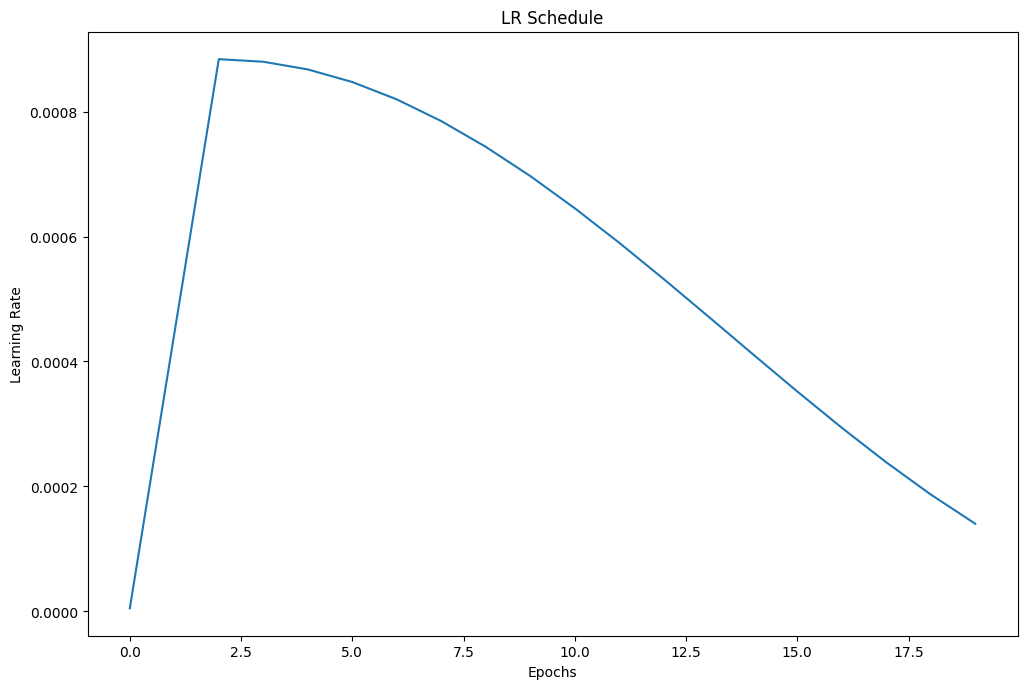

In [ ]:
def get_lr_callback(batch_size=8*16, return_fn = False):

    LR_START = 0.000005
    LR_MIN = 0.000005
    LR_MAX = 5e-5
    LR_MAX = 5.0/ (np.power(2, 2.5) * np.power(10, 3))
    LR_RAMPUP_EPOCHS = 2
    LR_SUSTAIN_EPOCHS = 0
    N_CYCLES = .5
    EPOCHS = P.epochs

    def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
            lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
            if LR_MIN is not None:
                lr = tf.math.maximum(LR_MIN, lr)
                
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    if return_fn:
        return lrfn
    return lr_callback


lrfn = get_lr_callback(return_fn = True)

lrs = []
for i in range(20):
    lrs.append(lrfn(i))

import matplotlib.pyplot as plt

plt.plot([float(lr) for lr in lrs])
plt.title("LR Schedule")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")

# TRAINING

This will crash usually after the 5th fold due to a memory leak. To address this, the training process will save results for each fold and automatically skip completed folds. Make sure to save the fold results in an accessible and permanent directory. I recommend google drive storage and specifically the approach described in https://stackoverflow.com/questions/52808143/colab-automatic-authentication-of-connection-to-google-drive-persistent-per-n/60103029#60103029. 

In [ ]:
folds = P.folds
kfold = KFold(folds, shuffle = True, random_state = 42)

histories = []

for f, (trn_ind, val_ind) in tqdm(enumerate(kfold.split(data['input_ids'])), total = folds): 

    # upate the save path here 
    path_to_save_directory = ''
    model_name = path_to_save_directory + P.config_name + '_f{:02}'.format(f) 
    print(model_name)
    

    try:
        hist = pd.read_csv(model_name + '.csv')

        assert len(hist) == P.epochs

        print('skipping fold %i' % f)

    except:

        hist = []

        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        train_dataset = get_dataset(idx_slice_dictionary(data, trn_ind),
                                    shuffle=True,
                                    noisy=True,
                                    repeat=True,
                                    to_xy = True,
                                    limit = True
                                    )
        
        valid_dataset = get_dataset(idx_slice_dictionary(data, val_ind),
                                    shuffle=False,
                                    noisy=False,
                                    repeat=False,
                                    to_xy = True
                                    )




        lr_schedule = get_lr_callback()
        csvlog =  tf.keras.callbacks.CSVLogger(model_name + '.csv')

        model = get_model() 


        history = model.fit(train_dataset, 
            steps_per_epoch  = P.steps_per_epoch,
            epochs           = P.epochs, 
            validation_data = valid_dataset,
            callbacks = [lr_schedule, csvlog],
            )

        histories.append(history)
        
        del train_dataset
        del valid_dataset
        del model 

skipping fold 0
skipping fold 1
skipping fold 2
skipping fold 3
skipping fold 4
skipping fold 5


INFO:tensorflow:Initializing the TPU system: grpc://10.116.173.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.173.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                

78/78 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5039WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


78/78 [==============================] - 221s 1s/step - loss: 0.7057 - accuracy: 0.5042 - val_loss: 0.6659 - val_accuracy: 0.5951
Epoch 2/25
78/78 [==============================] - 86s 1s/step - loss: 0.5749 - accuracy: 0.7040 - val_loss: 0.4050 - val_accuracy: 0.8279
Epoch 3/25
78/78 [==============================] - 86s 1s/step - loss: 0.5158 - accuracy: 0.7610 - val_loss: 0.3836 - val_accuracy: 0.8386
Epoch 4/25
78/78 [==============================] - 86s 1s/step - loss: 0.5106 - accuracy: 0.7654 - val_loss: 0.3781 - val_accuracy: 0.8462
Epoch 5/25
78/78 [==============================] - 86s 1s/step - loss: 0.5019 - accuracy: 0.7738 - val_loss: 0.3900 - val_accuracy: 0.8430
Epoch 6/25
78/78 [==============================] - 86s 1s/step - loss: 0.5000 - accuracy: 0.7748 - val_loss: 0.3653 - val_accuracy: 0.8521
Epoch 7/25
78/78 [==============================] - 86s 1s/step - loss: 0.4885 - accuracy: 0.7833 - val_loss: 0.3704 - val_accuracy: 0.8508
Epoch 8/25
78/78 [============

INFO:tensorflow:Initializing the TPU system: grpc://10.116.173.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.173.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                

78/78 [==============================] - ETA: 0s - loss: 0.7664 - accuracy: 0.4982WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


78/78 [==============================] - 225s 1s/step - loss: 0.7661 - accuracy: 0.4982 - val_loss: 0.6966 - val_accuracy: 0.5288
Epoch 2/25
78/78 [==============================] - 86s 1s/step - loss: 0.5855 - accuracy: 0.6900 - val_loss: 0.4068 - val_accuracy: 0.8322
Epoch 3/25
78/78 [==============================] - 86s 1s/step - loss: 0.5188 - accuracy: 0.7620 - val_loss: 0.3927 - val_accuracy: 0.8394
Epoch 4/25
78/78 [==============================] - 86s 1s/step - loss: 0.5130 - accuracy: 0.7640 - val_loss: 0.3735 - val_accuracy: 0.8449
Epoch 5/25
78/78 [==============================] - 86s 1s/step - loss: 0.5029 - accuracy: 0.7731 - val_loss: 0.3663 - val_accuracy: 0.8471
Epoch 6/25
78/78 [==============================] - 86s 1s/step - loss: 0.4944 - accuracy: 0.7777 - val_loss: 0.3787 - val_accuracy: 0.8432
Epoch 7/25
78/78 [==============================] - 86s 1s/step - loss: 0.4842 - accuracy: 0.7837 - val_loss: 0.3753 - val_accuracy: 0.8491
Epoch 8/25
78/78 [============

INFO:tensorflow:Initializing the TPU system: grpc://10.116.173.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.173.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                

78/78 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5461WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


78/78 [==============================] - 226s 1s/step - loss: 0.6910 - accuracy: 0.5464 - val_loss: 0.6288 - val_accuracy: 0.6662
Epoch 2/25
78/78 [==============================] - 86s 1s/step - loss: 0.5620 - accuracy: 0.7223 - val_loss: 0.4011 - val_accuracy: 0.8299
Epoch 3/25
78/78 [==============================] - 86s 1s/step - loss: 0.5139 - accuracy: 0.7636 - val_loss: 0.3938 - val_accuracy: 0.8406
Epoch 4/25
78/78 [==============================] - 86s 1s/step - loss: 0.5102 - accuracy: 0.7674 - val_loss: 0.3725 - val_accuracy: 0.8460
Epoch 5/25
78/78 [==============================] - 86s 1s/step - loss: 0.5044 - accuracy: 0.7721 - val_loss: 0.3702 - val_accuracy: 0.8480
Epoch 6/25
78/78 [==============================] - 86s 1s/step - loss: 0.4950 - accuracy: 0.7774 - val_loss: 0.3659 - val_accuracy: 0.8495
Epoch 7/25
78/78 [==============================] - 86s 1s/step - loss: 0.4819 - accuracy: 0.7862 - val_loss: 0.3626 - val_accuracy: 0.8507
Epoch 8/25
78/78 [============

INFO:tensorflow:Initializing the TPU system: grpc://10.116.173.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.173.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                

78/78 [==============================] - ETA: 0s - loss: 0.7149 - accuracy: 0.4954WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


78/78 [==============================] - 228s 1s/step - loss: 0.7148 - accuracy: 0.4956 - val_loss: 0.6725 - val_accuracy: 0.5801
Epoch 2/25
78/78 [==============================] - 86s 1s/step - loss: 0.5752 - accuracy: 0.7053 - val_loss: 0.4069 - val_accuracy: 0.8338
Epoch 3/25
78/78 [==============================] - 86s 1s/step - loss: 0.5178 - accuracy: 0.7644 - val_loss: 0.4099 - val_accuracy: 0.8304
Epoch 4/25
78/78 [==============================] - 86s 1s/step - loss: 0.5114 - accuracy: 0.7654 - val_loss: 0.3839 - val_accuracy: 0.8444
Epoch 5/25
78/78 [==============================] - 86s 1s/step - loss: 0.5033 - accuracy: 0.7717 - val_loss: 0.3729 - val_accuracy: 0.8484
Epoch 6/25
78/78 [==============================] - 86s 1s/step - loss: 0.4987 - accuracy: 0.7731 - val_loss: 0.3610 - val_accuracy: 0.8521
Epoch 7/25
78/78 [==============================] - 86s 1s/step - loss: 0.4876 - accuracy: 0.7844 - val_loss: 0.3712 - val_accuracy: 0.8520
Epoch 8/25
78/78 [============